# 注意力评分函数
:label:`sec_attention-scoring-functions`

 :numref:`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
 :eqref:`eq_nadaraya-watson-gaussian`中的
高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到softmax函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现
 :numref:`fig_qkv`中的注意力机制框架。
 :numref:`fig_attention_output`说明了
如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/attention-output.svg?raw=1)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


In [217]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**掩蔽softmax操作**]

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在 :numref:`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数
实现了这样的*掩蔽softmax操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为0。


In [218]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了[**演示此函数是如何工作**]的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。


In [219]:
x, valid_lens = torch.rand(2, 2, 4), torch.tensor([2, 3])

In [220]:
x

tensor([[[0.8938, 0.2939, 0.8904, 0.0103],
         [0.3575, 0.1264, 0.6894, 0.7604]],

        [[0.0415, 0.4093, 0.5530, 0.3502],
         [0.5239, 0.0775, 0.3399, 0.6994]]])

In [221]:
valid_lens

tensor([2, 3])

In [222]:
masked_softmax(x, valid_lens )

tensor([[[0.6456, 0.3544, 0.0000, 0.0000],
         [0.5575, 0.4425, 0.0000, 0.0000]],

        [[0.2432, 0.3513, 0.4056, 0.0000],
         [0.4046, 0.2589, 0.3366, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。


In [223]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2627, 0.4783, 0.2591, 0.0000]],

        [[0.5935, 0.4065, 0.0000, 0.0000],
         [0.1990, 0.3725, 0.1939, 0.2346]]])

## [**加性注意力**]

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。
如 所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。


In [224]:
class AdditiveAttention(nn.Module):
    """
    加性注意力
    """
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        """
        key_size: key的节点数 
        query_size: query的节点数
        num_hiddens: value的节点数
        """
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)     # key_size, num_hiddens    
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)   # query_size, num_hiddens
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)            # num_hiddens, 1
        self.dropout = nn.Dropout(dropout)   

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)           # 
        print(queries.shape, keys.shape)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)

        scores = self.w_v(features).squeeze(-1)

        self.attention_weights = masked_softmax(scores, valid_lens)

        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来[**演示上面的`AdditiveAttention`类**]，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。


In [225]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

In [226]:
queries, queries.shape

(tensor([[[ 0.0496,  1.3244, -0.8430,  0.0502, -0.2372, -1.0603,  1.7051,
           -1.3643, -0.5328,  0.0284,  0.9638,  0.3655, -0.4516,  0.0553,
           -0.7768,  2.2911, -0.3148, -0.0550,  1.2927,  1.2732]],
 
         [[ 0.2866, -0.5192,  0.1742,  0.2335,  0.1136,  0.8866,  0.8989,
           -0.4650, -0.0244, -2.3334,  1.7163, -0.8803,  1.3023,  0.7462,
            0.5173,  0.7117, -0.7643,  0.8644,  1.6849, -0.5678]]]),
 torch.Size([2, 1, 20]))

In [227]:
keys.shape

torch.Size([2, 10, 2])

In [228]:
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)

valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
# 评估模式
attention.eval()

attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 8]) torch.Size([2, 10, 8])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以[**注意力权重**]是均匀的，由指定的有效长度决定。


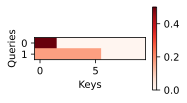

In [229]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [230]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) # 点积的值会随着节点数而变大, 通过d的平方根可以进行缩放
        self.attention_weights = masked_softmax(scores, valid_lens) # 通过遮掩, 屏蔽无效字段的分数
        return torch.bmm(self.dropout(self.attention_weights), values)  

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [231]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [232]:
queries.shape, keys.shape, values.shape, valid_lens

(torch.Size([2, 1, 2]),
 torch.Size([2, 10, 2]),
 torch.Size([2, 10, 4]),
 tensor([2, 6]))

In [233]:
ms = masked_softmax(values, valid_lens)
ms.shape

torch.Size([2, 10, 4])

In [234]:
ms

tensor([[[0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000],
         [0.2689, 0.7311, 0.0000, 0.0000]],

        [[0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439],
         [0.0321, 0.0871, 0.2369, 0.6439]]])

In [235]:
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000e+00,  3.0000e+00, -1.0000e+06, -1.0000e+06]],

        [[ 1.0000e+01,  1.1000e+01,  1.2000e+01,  1.3000e+01]]])

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


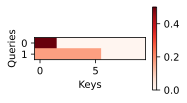

In [236]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。


## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？

In [237]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) # 点积的值会随着节点数而变大, 通过d的平方根可以进行缩放
        self.attention_weights = masked_softmax(scores, valid_lens) # 通过遮掩, 屏蔽无效字段的分数
        return torch.bmm(self.dropout(self.attention_weights), values)  

In [238]:
queries = torch.arange(20).reshape(2, 5, 2) / 20 
keys = torch.arange(40).reshape(2, 10, 2) / 40
values = (torch.arange(40).reshape(2, 10, 2) - 20 / 20 )

In [239]:
values.shape

torch.Size([2, 10, 2])

In [240]:
valid_lens = torch.tensor([3, 9])

In [241]:
attention = DotProductAttention(0.3)

In [242]:
attention(queries, keys, values, valid_lens)

tensor([[[ 0.4762,  0.9524],
         [ 1.9174,  2.8740],
         [ 0.4762,  0.9523],
         [-0.4653,  0.0000],
         [ 0.4760,  0.9521]],

        [[25.6816, 26.6280],
         [26.6033, 27.5612],
         [25.0884, 26.0197],
         [31.4434, 32.5639],
         [26.1334, 26.9973]]])

In [243]:
attention.attention_weights.shape

torch.Size([2, 5, 10])

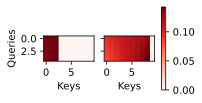

In [244]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 2, 5, 10)),
                  xlabel='Keys', ylabel='Queries')

2. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？

> 不能

3. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？

[Discussions](https://discuss.d2l.ai/t/5752)
